# Building a 5000 dimensional Logistic Regression Sentiment Classifier Based on the Netflix Large Movie Review dataset
The final exercise in Chapter 4 suggests implementing a final project for sentiment analysis. "Sentiment analysis can be considered a binary classification problem. The input is natural language text, and the output is a binary decision that infers positive or negative sentiment." The chapter end suggests taking a look at some datasets in particular the [Large Movie Review Dataset](http://mng.bz/60nj). The excercise also suggests visiting the Kaggle challenge for [Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial). 

The Kaggle tutorial is excellent, and I've borrowed big pieces from it. The main differences in the Kaggle tutorial are that they use Scikit-Learn and Random Forrest, and there is no Tensorflow in it. They also use Pandas and assume that the train data is a 25000 * 5000 column Pandas data frame, and that each vertical slice / column in the frame is the full term frequency feature set counts for word X1, word X2.... word XN.

I've made a few changes to the tutorial besides using Tensorflow. I outline them below:

   1. Instead of using [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), I used [Tika Python](http://github.com/chrismattmann/tika-python) to clean the review text. Should be obvious why...
   2. I added [TQDM](https://github.com/tqdm/tqdm) progress bars on the most important iterations. 
   3. I added some plots here and there, including looking at the term frequency distribution for the first 100 words in the 5000 word vocabulary, and a plot for the ROC curve.
   4. I added computation of precision and recall, and TP, TN, FP, FN
   5. I added saving for the model weights. 
   
I have a feeling I made this harder than it needed to be &#9786; That said, I couldn't even visualize based on the example given in the book for 2d logistic regresion what 5000d logistic regression looked like. So, I made a visual of it to hopefully help others when they are similarly thinking about it. I think once I learn more about Tensorflow, I will be able to clean this code up some more too. 

<img src="figs/ch04-final-bow-model.png" width="400" height="200" alt="Bag of Word Model in 5000 dimensions"/>

Here are some immensely useful references I found along the way. FWIW, my classifier is <b>~87%</b> accurate. Not bad!

## Useful References

   1. [Plot ROC Curve for Binary Classification](https://qiita.com/bmj0114/items/460424c110a8ce22d945) by @bmj0114
   2. [Intersecting Lists and Finding their Indices](https://stackoverflow.com/questions/12570417/python-finding-corresponding-indices-for-an-intersection-of-two-lists) by mgilson
   3. [An Introduction to Bag of Words](https://medium.freecodecamp.org/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04) by Free Code Camp.
   4. [Bag of Words Meets Popcorn Tutorial](https://www.kaggle.com/c/word2vec-nlp-tutorial/overview) by Kaggle.
   5. [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/) by Stanford.
   6. [What Bag of Words Looks Like Visually](https://bit.ly/2KCTYGe) by Unknown.
   7. [Working with Bag of Words - Tensorflow Cookbook](https://github.com/nfmcclure/tensorflow_cookbook/blob/master/07_Natural_Language_Processing/02_Working_with_Bag_of_Words/02_bag_of_words.ipynb) by Nick F. Mcclure.


In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tika import parser
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
import re
from tqdm import tqdm_notebook as tqdm
from os import listdir
from os.path import isfile, join
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package movie_review

True

In [2]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = parser.from_buffer( "<html>" + raw_review + "</html>" )["content"]
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words )) 

In [3]:
train = pd.read_csv("word2vec-nlp-tutorial/labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [4]:
train.shape

(25000, 3)

In [5]:
train.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

In [6]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [7]:
parsed = parser.from_buffer("<html>"+train["review"][0]+"</html>")
print(train["review"][0])
print(parsed["content"])

2019-04-14 16:17:59,539 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [8]:
# Get the number of reviews based on the dataframe column size
num_reviews = train["review"].size

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in tqdm(range( 0, num_reviews )):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    clean_train_reviews.append( review_to_words( train["review"][i] ) )

In [9]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

In [10]:
print(train_data_features.shape)

(25000, 5000)


In [11]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print("size %d %s " % (len(vocab), vocab))

size 5000 ['abandoned', 'abc', 'abilities', 'ability', 'able', 'abraham', 'absence', 'absent', 'absolute', 'absolutely', 'absurd', 'abuse', 'abusive', 'abysmal', 'academy', 'accent', 'accents', 'accept', 'acceptable', 'accepted', 'access', 'accident', 'accidentally', 'accompanied', 'accomplished', 'according', 'account', 'accuracy', 'accurate', 'accused', 'achieve', 'achieved', 'achievement', 'acid', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'activities', 'actor', 'actors', 'actress', 'actresses', 'acts', 'actual', 'actually', 'ad', 'adam', 'adams', 'adaptation', 'adaptations', 'adapted', 'add', 'added', 'adding', 'addition', 'adds', 'adequate', 'admire', 'admit', 'admittedly', 'adorable', 'adult', 'adults', 'advance', 'advanced', 'advantage', 'adventure', 'adventures', 'advertising', 'advice', 'advise', 'affair', 'affect', 'affected', 'afford', 'aforementioned', 'afraid', 'africa', 'african', 'afternoon', 'afterwards', 'age', 'aged', 'agent', 'agents', 'ages', 'aging', 

In [12]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print("%d, %s" % (count, tag))

187, abandoned
125, abc
108, abilities
454, ability
1259, able
85, abraham
116, absence
83, absent
352, absolute
1485, absolutely
306, absurd
192, abuse
91, abusive
98, abysmal
297, academy
485, accent
203, accents
300, accept
130, acceptable
144, accepted
92, access
318, accident
200, accidentally
88, accompanied
124, accomplished
296, according
186, account
81, accuracy
284, accurate
123, accused
179, achieve
139, achieved
124, achievement
90, acid
971, across
1251, act
660, acted
6494, acting
3355, action
311, actions
83, activities
2389, actor
4488, actors
1219, actress
369, actresses
394, acts
793, actual
4240, actually
148, ad
303, adam
98, adams
454, adaptation
80, adaptations
154, adapted
810, add
440, added
166, adding
347, addition
337, adds
113, adequate
124, admire
621, admit
134, admittedly
101, adorable
511, adult
376, adults
101, advance
90, advanced
153, advantage
510, adventure
204, adventures
91, advertising
259, advice
90, advise
346, affair
93, affect
113, affected


450, glad
157, glass
80, glasses
118, glenn
149, glimpse
94, global
104, glorious
147, glory
142, glover
5159, go
137, goal
1209, god
134, godfather
105, godzilla
2442, goes
4102, going
296, gold
123, goldberg
260, golden
754, gone
241, gonna
15147, good
106, goodness
161, goofy
245, gordon
1040, gore
369, gorgeous
234, gory
3587, got
136, gothic
129, gotta
286, gotten
424, government
109, grab
80, grabs
328, grace
462, grade
118, gradually
86, graham
307, grand
98, grandfather
127, grandmother
262, grant
201, granted
239, graphic
169, graphics
97, grasp
237, gratuitous
189, grave
121, gray
89, grayson
9061, great
174, greater
745, greatest
154, greatly
82, greatness
86, greed
91, greedy
113, greek
404, green
83, greg
79, gregory
250, grew
158, grey
79, grief
102, griffith
188, grim
103, grinch
150, gripping
196, gritty
180, gross
353, ground
1034, group
108, groups
224, grow
298, growing
252, grown
134, grows
163, gruesome
91, guarantee
167, guard
1310, guess
99, guessed
151, guessing

296, moon
227, moore
366, moral
122, morality
275, morgan
266, morning
83, moronic
98, morris
941, mostly
1524, mother
450, motion
122, motivation
95, motivations
103, motives
196, mountain
110, mountains
168, mouse
332, mouth
727, move
322, moved
207, movement
115, movements
530, moves
44047, movie
7668, movies
854, moving
1448, mr
260, mrs
350, ms
180, mst
86, mtv
9766, much
140, multi
190, multiple
108, mummy
86, mundane
1063, murder
260, murdered
179, murderer
109, murderous
367, murders
213, murphy
81, murray
96, museum
3057, music
992, musical
175, musicals
85, muslim
3250, must
97, myers
105, mysteries
405, mysterious
850, mystery
98, nail
218, naive
437, naked
1604, name
800, named
96, namely
391, names
227, nancy
192, narration
424, narrative
125, narrator
342, nasty
82, nathan
187, nation
255, national
238, native
463, natural
267, naturally
711, nature
162, navy
190, nazi
114, nazis
145, nd
824, near
109, nearby
815, nearly
149, neat
180, necessarily
324, necessary
141, neck

87, widely
155, widmark
105, widow
2140, wife
432, wild
80, wilderness
596, william
344, williams
85, willie
320, willing
92, willis
200, wilson
491, win
274, wind
257, window
102, winds
177, wing
232, winner
348, winning
164, wins
138, winter
105, winters
89, wisdom
359, wise
957, wish
95, wished
154, wishes
85, wishing
234, wit
322, witch
92, witches
832, within
3267, without
210, witness
88, witnessed
89, witnesses
273, witty
105, wives
95, wizard
120, wolf
2796, woman
1819, women
1038, wonder
126, wondered
1658, wonderful
324, wonderfully
359, wondering
125, wonders
101, wont
80, woo
271, wood
330, wooden
400, woods
240, woody
927, word
885, words
98, wore
4374, work
635, worked
129, worker
165, workers
794, working
1279, works
3835, world
143, worlds
88, worn
117, worried
142, worry
1469, worse
2732, worst
2278, worth
126, worthless
187, worthwhile
362, worthy
12436, would
94, wound
84, wounded
432, wow
87, wrap
92, wrapped
127, wreck
103, wrestling
79, wretched
670, write
1153, w

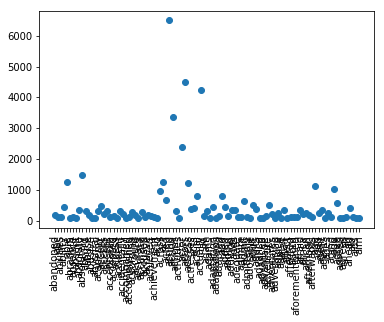

In [13]:
# plot the word count for first 100 words
plt.scatter(vocab[0:99], dist[0:99])
plt.xticks(vocab[0:99], rotation='vertical')
plt.show()

In [14]:
# set up Tensorflow nD logistic regression
learning_rate = 0.1
training_epochs = 2000

In [15]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [16]:
Y = tf.placeholder(tf.float32, shape=(None,), name="y")
w = tf.Variable([0.] * (len(train_data_features)+1), name="w", trainable=True)

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
ys = train['sentiment'].values

In [18]:
Xs = {}
for i in range(train_data_features.shape[1]):
    Xs["X"+str(i)] = tf.placeholder(tf.float32, shape=(None,), name="x"+str(i))

In [19]:
linear = w[0]
for i in range(0, train_data_features.shape[1]):
    linear = linear + (w[i+1] * Xs["X"+str(i)])
y_model = tf.sigmoid(linear)

In [20]:
cost = tf.reduce_mean(-tf.log(y_model * Y + (1 - y_model) * (1 - Y)))
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [21]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    prev_err = 0
    for epoch in tqdm(range(training_epochs)):
        feed_dict = {}
        for i in range(train_data_features.shape[1]):
            feed_dict[Xs["X"+str(i)]] = train_data_features[:, i, None].reshape(len(train_data_features))
        feed_dict[Y] = ys
        err, _ = sess.run([cost, train_op], feed_dict=feed_dict)
        print(epoch, err)
        if abs(prev_err - err) < 0.0001:
            break
        prev_err = err
    
    w_val = sess.run(w, feed_dict)
    save_path = saver.save(sess, "./en-netflix-binary-sentiment.ckpt")

0 0.6931475
1 0.68367267
2 0.67517424
3 0.6673778
4 0.6601468
5 0.6533886
6 0.6470343
7 0.64103085
8 0.6353368
9 0.62991923
10 0.62475115
11 0.6198105
12 0.6150785
13 0.6105392
14 0.6061786
15 0.6019846
16 0.59794647
17 0.59405404
18 0.5902991
19 0.58667326
20 0.5831693
21 0.5797805
22 0.5765007
23 0.5733241
24 0.57024544
25 0.5672598
26 0.5643625
27 0.5615493
28 0.5588163
29 0.55615956
30 0.5535756
31 0.55106133
32 0.5486133
33 0.546229
34 0.54390526
35 0.54163986
36 0.53943014
37 0.537274
38 0.535169
39 0.5331134
40 0.5311051
41 0.52914226
42 0.5272231
43 0.5253461
44 0.5235097
45 0.5217122
46 0.5199523
47 0.51822865
48 0.51654017
49 0.5148855
50 0.5132633
51 0.51167256
52 0.5101124
53 0.5085817
54 0.5070795
55 0.50560474
56 0.5041569
57 0.5027348
58 0.50133777
59 0.499965
60 0.49861583
61 0.49728957
62 0.49598548
63 0.49470282
64 0.4934411
65 0.4921997
66 0.49097803
67 0.48977554
68 0.48859173
69 0.4874259
70 0.48627788
71 0.48514712
72 0.4840329
73 0.482935
74 0.481853
75 0.4807864

569 0.3361943
570 0.3360846
571 0.33597508
572 0.33586586
573 0.3357568
574 0.3356481
575 0.33553946
576 0.3354311
577 0.33532292
578 0.335215
579 0.33510736
580 0.33499983
581 0.3348925
582 0.33478546
583 0.33467856
584 0.334572
585 0.3344655
586 0.33435938
587 0.3342533
588 0.33414757
589 0.33404186
590 0.3339366
591 0.3338314
592 0.3337264
593 0.3336217
594 0.3335171
595 0.33341283
596 0.33330867
597 0.3332047
598 0.33310097
599 0.3329974
600 0.33289415
601 0.33279103
602 0.33268812
603 0.33258536
604 0.3324828
605 0.33238044
606 0.3322783
607 0.33217642
608 0.33207464
609 0.33197314
610 0.33187172
611 0.3317706
612 0.3316696
613 0.3315689
614 0.33146828
615 0.33136788
616 0.33126768
617 0.33116767
618 0.3310678


In [22]:
print(w_val)
print(np.max(w_val))

[ 0.0028774  -0.00082148  0.01867105 ...  0.          0.
  0.        ]
0.49940136


In [23]:
def predict(test_review, vocab, weights, threshold=0.5):
    #clean the review
    test_review_c = review_to_words(test_review)
    
    #create the test vocabulary and counts
    n_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
    ex_data_features = n_vectorizer.fit_transform([test_review_c])
    ex_data_features = ex_data_features.toarray()
    test_vocab = n_vectorizer.get_feature_names()
    test_vocab_counts = ex_data_features.reshape(ex_data_features.shape[1])
    
    # figure out the intersection of the test vocabulary from the review with the actual full vocabulary
    ind_dict = dict((k, i) for i, k in enumerate(vocab))
    test_ind_dict = dict((k, i) for i, k in enumerate(test_vocab))
    inter = set(ind_dict).intersection(test_vocab)
    indices = [ ind_dict[x] for x in inter ]
    test_indices = [test_ind_dict[x] for x in inter]
    
    # all zeros for the 5000 feature vec except for the overlap indices that we have counts for
    test_feature_vec = np.zeros(train_data_features.shape[1])
    for i in range(len(indices)):
        test_feature_vec[indices[i]] = test_vocab_counts[test_indices[i]]
     
    # our log reg model
    test_linear = weights[0]
    for i in range(0, train_data_features.shape[1]):
        test_linear = test_linear + (weights[i+1] * test_feature_vec[i])
    y_test = sigmoid(test_linear)
    
    # here it is the prediction
    return np.greater(y_test, threshold).astype(float)

In [24]:
test = pd.read_csv("word2vec-nlp-tutorial/testData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [25]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [26]:
#try it out on new data
new_neg_review = "Man, this movie really sucked. It was terrible. I could not possibly watch this movie again!"
new_pos_review = "I think that this is a fantastic movie, it really "

In [27]:
new_neg_review_c = review_to_words(new_neg_review)
new_pos_review_c = review_to_words(new_pos_review)
print(new_neg_review_c)
print(new_pos_review_c)         

man movie really sucked terrible could possibly watch movie
think fantastic movie really


In [28]:
predict(new_neg_review, vocab, w_val)

0.0

In [29]:
predict(new_pos_review, vocab, w_val)

1.0

In [30]:
# Generate Kaggle Submission
# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
result = [] 
for i in tqdm(range(0, num_reviews)):
    r = predict(test["review"][i], vocab, w_val)
    result.append(r)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv( "Bag_of_Words_model.csv", index=False, quoting=3 )

In [31]:
# test on unseen samples from IMDB movie reviews and compute TP, TN, FP, FN and precision + accuracy
pos_test_path = "aclImdb/test/pos/"
neg_test_path = "aclImdb/test/neg/"
only_pos_files = [f for f in listdir(pos_test_path) if isfile(join(pos_test_path, f))]
only_neg_files = [f for f in listdir(neg_test_path) if isfile(join(neg_test_path, f))]

only_pos_file_contents = []
for i in range(0, len(only_pos_files)):
    with open(pos_test_path + only_pos_files[i], 'r') as file:
        r_data = file.read()
        only_pos_file_contents.append(r_data)
        
only_neg_file_contents = []
for i in range(0, len(only_neg_files)):
    with open(neg_test_path + only_neg_files[i], 'r') as file:
        r_data = file.read()
        only_neg_file_contents.append(r_data)

In [32]:
TP = 0.
TN = 0.
FP = 0.
FN = 0.
predictions_test = np.zeros(len(only_pos_file_contents) * 2)

In [33]:
for i in tqdm(range(0, len(only_pos_file_contents))):
    sent = predict(only_pos_file_contents[i], vocab, w_val)
    predictions_test[i] = sent
    if sent == 1.:
        TP += 1
    elif sent == 0.:
        FN += 1

In [34]:
for i in tqdm(range(0, len(only_neg_file_contents))):
    sent = predict(only_neg_file_contents[i], vocab, w_val)
    predictions_test[len(only_neg_file_contents)+i] = sent
    if sent == 0.:
        TN += 1
    elif sent == 1.:
        FP += 1

In [35]:
precision = (TP) / (TP + FP)

In [36]:
recall = (TP) / (TP + FN)

In [37]:
print("precision %f recall %f" % (precision, recall))

precision 0.859793 recall 0.875200


In [38]:
print(TP)
print(TN)
print(FP)
print(FN)

10940.0
10716.0
1784.0
1560.0


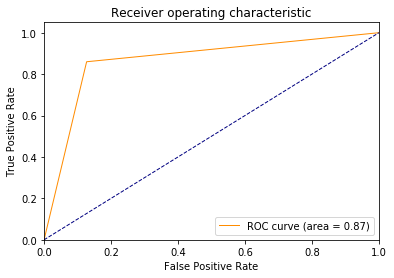

In [39]:
outcome_test = np.ones(len(only_pos_files))
outcome_test = np.append(outcome_test, np.zeros(len(only_neg_files)))

fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()